In [6]:
!jupyter nbconvert --to html presentation.ipynb

[NbConvertApp] Converting notebook presentation.ipynb to html
[NbConvertApp] Writing 310994 bytes to presentation.html


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt


from util.applyPressureSource import apply_pressure_source
from util.analyticDampingDensity import analytic_damping_density
from generate_StochasticRIR import generate_stochastic_rir

In [2]:
def generate_stochastic_rir_del(del_Kx, del_Ky, del_Kz, fs=48000, c=343, use_pressure_source=False):
    ###
    #
    # This function uses the difference of K's to predict in the correct order
    ####
    # Predefine L 
    L = torch.tensor([3,4,5])
    V = torch.prod(L)
    # 
    max_time = 2.0
    fs = 48000
    c = 343
    # derive K's
    Kx = del_Kx
    Ky = del_Ky + del_Kx
    Kz = del_Kz + del_Ky + del_Kx
    # if Ky.requires_grad : Ky.register_hook(lambda x : print("Ky: ", Ky.grad_fn,torch.isnan(x)))
    Kyxz = torch.concatenate((Kx.view(-1), Ky.view(-1), Kz.view(-1)))
    Kxyz = torch.minimum(Kyxz, torch.tensor(-0.0001))  # limit Kxyz to avoid division by 0
    # if Kxyz.requires_grad : Kxyz.register_hook(lambda x : print("Kxyz: ", Kxyz.grad_fn,torch.any(torch.isnan(x))))

    max_sigma = torch.max(Kxyz)
    min_sigma = -torch.norm(Kxyz)
    sigma = torch.linspace(min_sigma.item() - 0.01, max_sigma.item() + 0.01, 1000)
    
    H, p = analytic_damping_density(sigma, Kxyz, V)
    H = H / (4 * torch.pi)  # this is an unexplained tuning factor
    # if H.requires_grad : H.register_hook(lambda x : print("H", H.grad_fn,torch.any(torch.isnan(x))))
    # uniform sampling of damping density for the decay envelope
    time = torch.arange(1, max_time * fs + 1) / fs
    envelope = torch.sqrt(torch.exp(c * time.unsqueeze(1) * sigma) @ H * torch.mean(torch.diff(sigma)))

    # shape noise
    h = envelope * torch.randn(len(time))
    # if h.requires_grad : h.register_hook(lambda x : print("h", h.grad_fn, torch.any(torch.isnan(x))))
    # apply pressure source to match the color, but compensate the energy loss
    if use_pressure_source:
        h = apply_pressure_source(h)

    return h

In [3]:
# RIR model 2
class RIR_model2(torch.nn.Module):
    def __init__(self,) : 
        super().__init__()
        self.kx = torch.randint(-200, -100, (1,)).float()*0.0001
        self.ky = torch.randint(-200, -100, (1,)).float()*0.0001
        self.kz = torch.randint(-200, -100, (1,)).float()*0.0001
        self.kes = torch.sort(torch.cat([self.kx.view(-1), self.ky.view(-1), self.kz.view(-1)]))[0]
        self.del_Kx = torch.nn.Parameter(self.kes[0])
        self.del_Ky = torch.nn.Parameter(self.kes[1] - self.kes[0])
        self.del_Kz = torch.nn.Parameter(self.kes[2] - self.kes[1])
        
    def forward(self):
        return generate_stochastic_rir_del(del_Kx=self.del_Kx, del_Ky=self.del_Ky, del_Kz=self.del_Kz)

# Enveloped    
def env_makerF(inp, filter_len=2047, gain=None, clip_=None, title_str = '', display_plots=False):
    # Amplify
    if gain is not None:
        arr = inp * (10**(gain/20))
    else:
        arr = inp

    ## Main Evelope Block
    filter_= torch.ones(filter_len)
    filter_avg = filter_/torch.sum(filter_) # Avg filter
    sqq = arr**2    # Squaring for Power
    # Smoothing 
    smoothed = torch.nn.functional.conv1d(sqq.reshape(1,-1), filter_avg.reshape(1,1,-1), bias=None, stride=1, padding='same' ).reshape(-1,)
    sm2 = smoothed.clone()
    in_db = mag2db(sm2)    # Convert to dB scale

    # Clipping below -150/-100dB
    if clip_ is not None:
        in_db2 = torch.clip(in_db, min=clip_)
    else:
        in_db2 = in_db
    # Plot
    title_switch = {
        # 1: "RIR",
        # 2: "Squared RIR",
        1: "Smoothed",
        2: "in dB"

    }
    if display_plots:
        plt.figure(figsize=(14,4))
        for i, it in enumerate([smoothed, in_db2]):
            plt.subplot(1,2,i+1)
            plt.plot(it)
            plt.title(title_switch[i+1]+", Filter: "+title_str)
        plt.show()
    
    return in_db2

def mag2db(xcv):
    return 20 * xcv.log10_()

Target params: Kx:-0.02199999988079071, Ky:-0.01600000075995922, KZ:-0.012000000104308128
Target params Deltas: del_Kx:-0.02199999988079071, del_Ky:0.0059999991208314896, del_KZ:0.0040000006556510925

 Inital Params: 
del_Kx :  tensor(-0.0186)
del_Ky :  tensor(0.0046)
del_Kz :  tensor(0.0026)
Loss in epoch:0 is : 5.3741960525512695
Loss in epoch:25 is : 1.3305608034133911
Loss in epoch:50 is : 6.371147155761719
Loss in epoch:75 is : 1.1654223203659058
Loss in epoch:100 is : 2.1387906074523926
Loss in epoch:125 is : 1.05418062210083
Loss in epoch:150 is : 1.4931679964065552
Loss in epoch:175 is : 1.1854900121688843
Loss in epoch:200 is : 0.9222273230552673
Loss in epoch:225 is : 0.8395592570304871
Loss in epoch:250 is : 0.6790519952774048

 Updated Params:
del_Kx :  tensor(-0.0202)
del_Ky :  tensor(0.0044)
del_Kz :  tensor(0.0036)
Kx:  tensor(-0.0202)
Ky:  tensor(-0.0158)
Kz:  tensor(-0.0122)


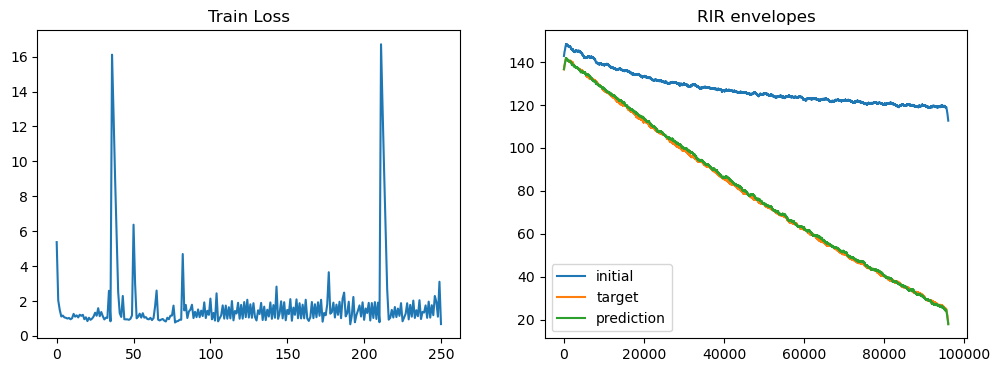

In [14]:
# delta K's model training
# training params
iter_ = 251
lr = 0.0000001
env_filter_len = 1023
signal_gain = 100    # dB
dB_clip = None
# K tensors
Kx=torch.tensor(-0.022) 
Ky=torch.tensor(-0.016)
Kz=torch.tensor(-0.012)
kes = torch.sort(torch.cat([Kx.view(-1), Ky.view(-1), Kz.view(-1)]))[0]
del_Kx = kes[0]
del_Ky = kes[1] - kes[0]
del_Kz = kes[2] - kes[1]
labels = generate_stochastic_rir_del(del_Kx=del_Kx, del_Ky=del_Ky, del_Kz=del_Kz)
# labels = generate_stochasticRIR(L=torch.Tensor([6,4,5]))#.cuda())#.cuda()
# labels = generate_stochastic_rir(Kx=Kx,Ky=Ky,Kz=Kz)
#l_env = torch.Tensor(ob.envelope(labels.detach())).float().requires_grad_().cuda()
l_env = env_makerF(labels, filter_len=env_filter_len , gain=signal_gain, clip_=dB_clip)#.float().requires_grad_().cuda()
#
mod = RIR_model2()#.cuda()
crit = torch.nn.MSELoss()#.cuda()
optim = torch.optim.SGD(mod.parameters(),lr=lr)
print(f"Target params: Kx:{np.round(Kx.numpy(), 4)}, Ky:{Ky}, KZ:{Kz}")
print(f"Target params Deltas: del_Kx:{del_Kx}, del_Ky:{del_Ky}, del_KZ:{del_Kz}")
print("\n Inital Params: ")
for name, param in mod.named_parameters():
    if param.requires_grad:
        print( name,': ', param.data)
# print("\n")
# plt.figure(1)
# plt.plot(labels)
# #plt.show()
# y_env = env_maker0(labels)
# plt.figure(2)
# plt.plot(y_env)
# plt.show()


t_l = []
for i in range(iter_):
    optim.zero_grad()
    y_hat = mod.forward()
    x_env = env_makerF(y_hat, filter_len=env_filter_len , gain=signal_gain, clip_=dB_clip)
    # l = crit(labels, y_hat)
    #l = crit(x_env, l_env)
    l = torch.mean(torch.abs(x_env - l_env))
    l.backward()
    optim.step()
    t_l.append(l.detach().cpu())
    if i%25 == 0 : print(f'Loss in epoch:{i} is : {l.detach()}')

final_param_dict = {}
print("\n Updated Params:")
for name, param in mod.named_parameters():
    if param.requires_grad:
        print( name,': ', param.data)
        final_param_dict.update({name: param.data.clone()})
# print params
print("Kx: ", final_param_dict['del_Kx'])
print("Ky: ", final_param_dict['del_Ky'] + final_param_dict['del_Kx'])
print("Kz: ", final_param_dict['del_Kz'] + final_param_dict['del_Ky']+ final_param_dict['del_Kx'])
#
plt.figure(1, figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(t_l,)# linestyle='', marker='.')
plt.title("Train Loss")
plt.subplot(1,2,2)
plt.plot(env_makerF(generate_stochastic_rir(Kx=final_param_dict['del_Kx'], Ky=final_param_dict['del_Ky'], Kz=final_param_dict['del_Kz']), filter_len=1023, gain=100), label='initial')
plt.plot(l_env,  label='target')
plt.plot(env_makerF(mod.forward().detach(), filter_len=1023, gain=100), label='prediction')
plt.title("RIR envelopes")
plt.legend()
plt.show()